In [940]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import torch
from torch import nn

from src.plot_utils import plot_feature, plot_groupby, crossplot_pred
from src.train_utils import create_dataloader, train, predict
from src.losses import AsymmetricMSELoss, AsymmetricBCELoss
from src.models import TimeSeriesTransformer

### Main block

[Constants](#Constants)<br>
[Exploratory data analysis](#Exploratory-data-analysis)<br>
[Problem statement](#Problem-statement)<br>
[Data preprocessing](#Data-preprocessing)<br>
[Baseline Model](#Baseline-model)<br>
[Transformers](#Transformers)<br>
[Сonclusions](#Conclusions)<br>

## Constants

In [958]:
TRAIN_SPLIT_SIZE = .8
SEED = 42

# transformers
BATCH_SIZE = 256
LR = 0.01
WEIGHT_DECAY = 0.01
N_EPOCHS = 60
WINDOW_SIZE = 30

## Exploratory data analysis

In [6]:
data_path = './data/data.csv'

In [7]:
df = pd.read_csv(data_path)

In [8]:
df.head(10)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
5,1,6,518.67,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,...,23.3669,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,-0.0043,-0.0001
6,1,7,518.67,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,...,23.3774,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,0.0010,0.0001
7,1,8,518.67,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,...,23.3106,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,-0.0034,0.0003
8,1,9,518.67,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,...,23.4066,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,0.0008,0.0001
9,1,10,518.67,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,...,23.4694,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,-0.0033,0.0001


In [9]:
df.tail(10)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
16128,80,176,518.67,1.3,47.92,521.08,2388.20,8204.48,8.5111,0.03,...,23.1720,1600.14,1428.42,14.62,21.61,552.11,2388.12,9139.28,0.0014,0.0001
16129,80,177,518.67,1.3,48.07,520.15,2388.11,8206.52,8.4967,0.03,...,23.0713,1603.93,1423.61,14.62,21.61,551.94,2388.17,9143.78,-0.0004,0.0004
16130,80,178,518.67,1.3,48.12,520.80,2388.18,8216.30,8.5173,0.03,...,23.1038,1603.07,1420.15,14.62,21.61,551.81,2388.09,9149.03,0.0000,0.0000
16131,80,179,518.67,1.3,48.06,520.50,2388.10,8211.19,8.4860,0.03,...,23.1907,1613.29,1432.42,14.62,21.61,551.59,2388.15,9144.00,-0.0006,-0.0003
16132,80,180,518.67,1.3,48.03,520.01,2388.12,8215.84,8.5194,0.03,...,23.0692,1602.87,1422.70,14.62,21.61,551.54,2388.17,9155.94,0.0005,-0.0002
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,...,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,...,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,...,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,...,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002
16137,80,185,518.67,1.3,48.05,520.00,2388.18,8229.73,8.5250,0.03,...,23.0323,1606.38,1421.41,14.62,21.61,551.55,2388.22,9170.57,0.0015,0.0000


In [10]:
# Let's look unique id of timeseries in dataset
df.id.unique().shape 

(80,)

Try to find constant features. Each p-th and s-th element of dataset is float number. I don't want to use `unique` function for floats so we could calculate std to find a zero.

In [11]:
df.std()

id       2.339535e+01
cycle    6.591530e+01
p00      0.000000e+00
p01      2.220515e-16
p02      2.674218e-01
p03      7.382523e-01
p04      7.260372e-02
p05      1.973135e+01
p06      3.751962e-02
p07      1.387822e-17
p08      1.549031e+00
p09      0.000000e+00
p10      0.000000e+00
p11      5.007111e-01
p12      1.810428e-01
p13      1.086055e-01
p14      6.129960e+00
p15      8.977073e+00
p16      3.552824e-15
p17      1.417433e-03
p18      8.879473e-01
p19      7.160782e-02
p20      2.278136e+01
s1       2.188188e-03
s2       2.939096e-04
dtype: float64

`p00`, `p09`, `p10` are constant values and could be removed from dataset without loss of information. <br>
`p01`, `p07`, `p16` have a std is very close to zero, so it looks like a contant values. A non-zero value of std is an error of float calculation.

Text(0.5, 1.0, 'Max cycle of timeseries. min: 128, max: 362')

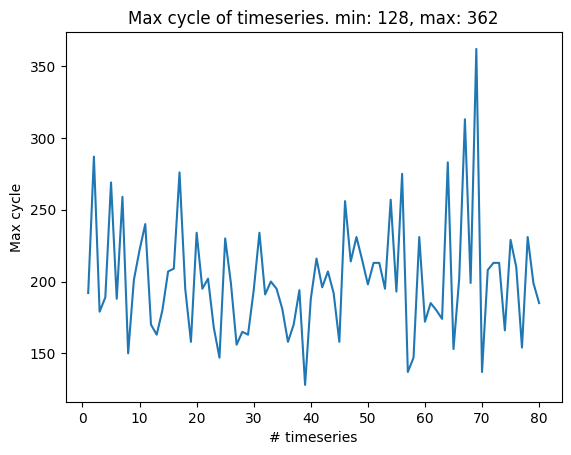

In [12]:
cycle_max = df.groupby(by='id')['cycle'].max()
plt.plot(cycle_max)
plt.xlabel('# timeseries')
plt.ylabel('Max cycle')
plt.title(f'Max cycle of timeseries. min: {cycle_max.min()}, max: {cycle_max.max()}')

Split the dataset by timeseries and look for statistsics by each timeseries.

There are a lot of numbers. Let's visualize it.

In [13]:
df_drop = df.drop(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], axis=1)

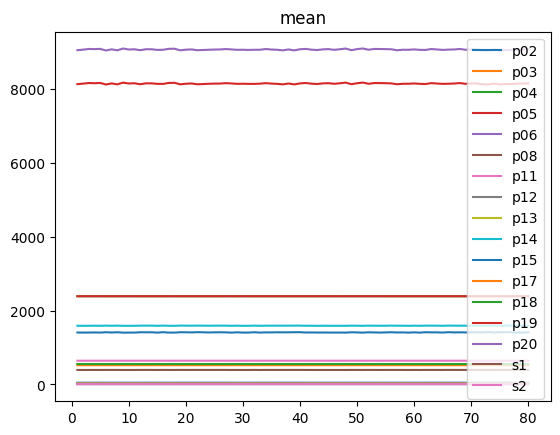

In [14]:
plot_groupby(df_drop, 'mean', show_labels=True)

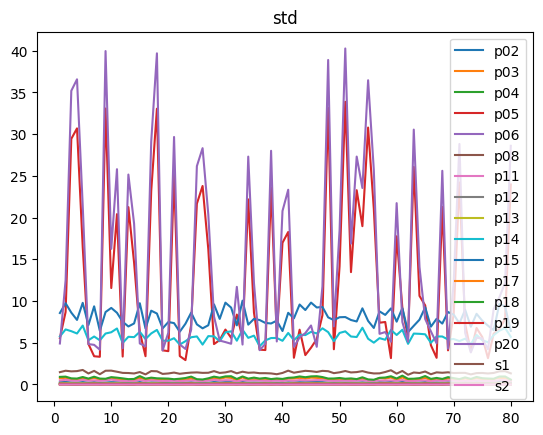

In [15]:
plot_groupby(df_drop, 'std', show_labels=True)

Text(0.5, 1.0, 'p20 range of timeseries. min: 19.140, max: 188.170')

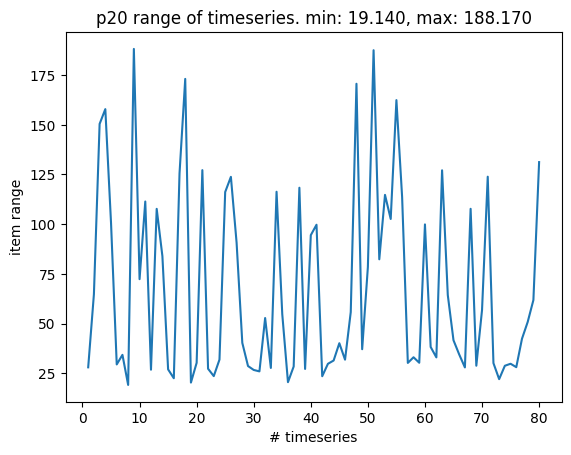

In [16]:
item = 'p20'
item_range = df.groupby(by='id')[item].max() - df.groupby(by='id')[item].min()
plt.plot(item_range)
plt.xlabel('# timeseries')
plt.ylabel('item range')
plt.title(f'{item} range of timeseries. min: {item_range.min():.3f}, max: {item_range.max():.3f}')

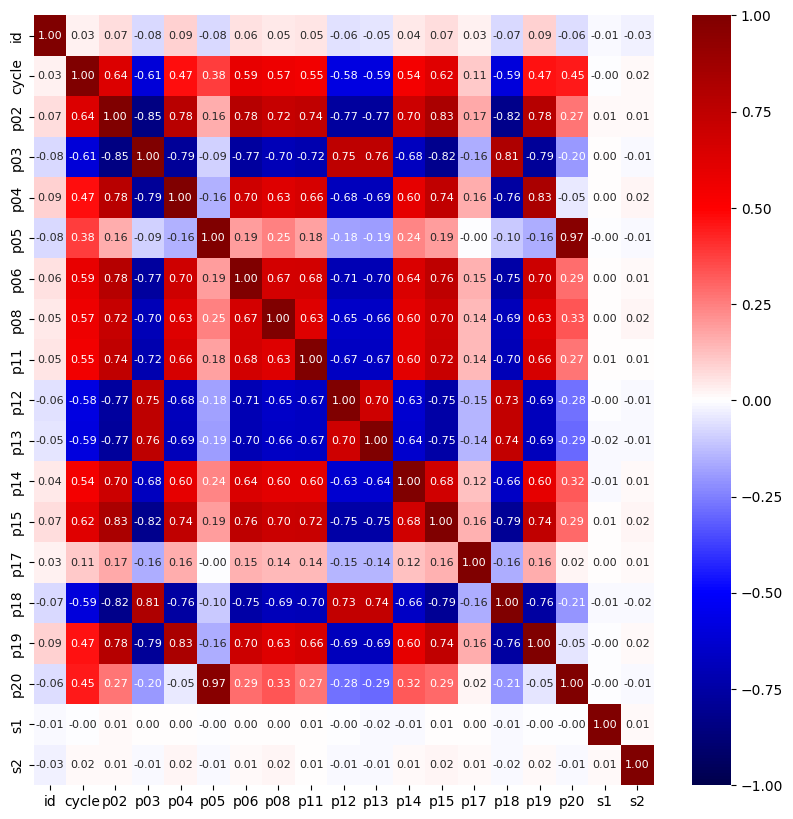

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(df_drop.corr(), ax=ax, cmap='seismic', vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 8}, fmt=".2f")

### Plot some features

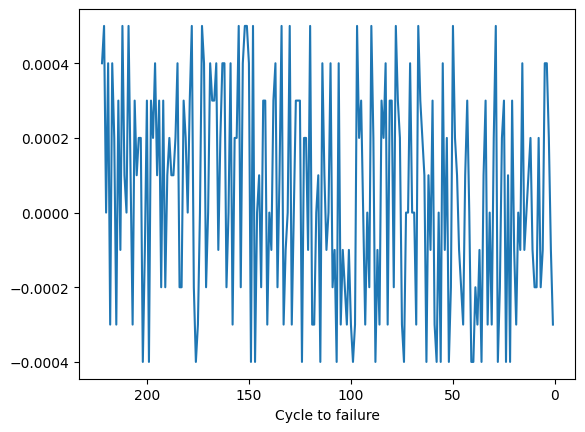

In [14]:
plot_feature(df, 's2', timeseries=[10])

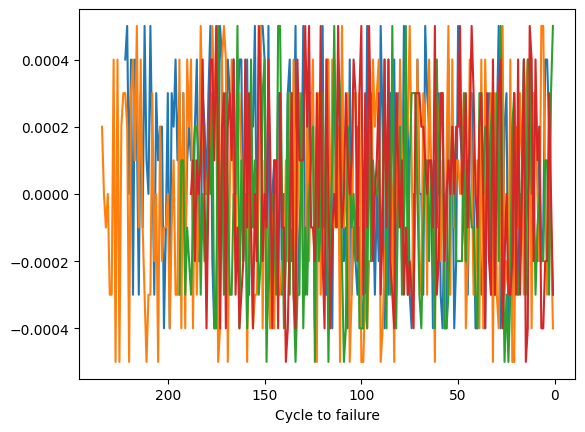

In [15]:
plot_feature(df, 's2', timeseries=[10, 20, 30, 40])

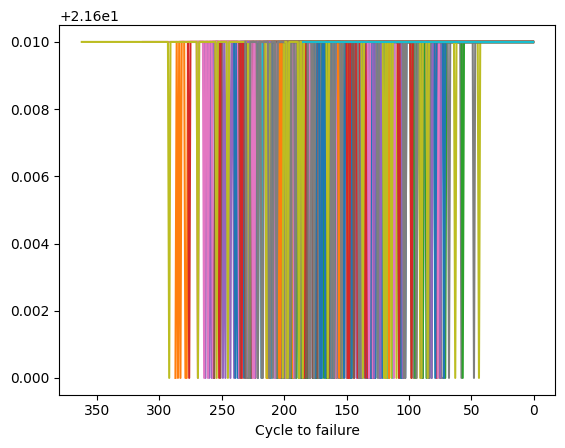

In [16]:
plot_feature(df, 'p17')

In [17]:
df.p17.unique()

array([21.61, 21.6 ])

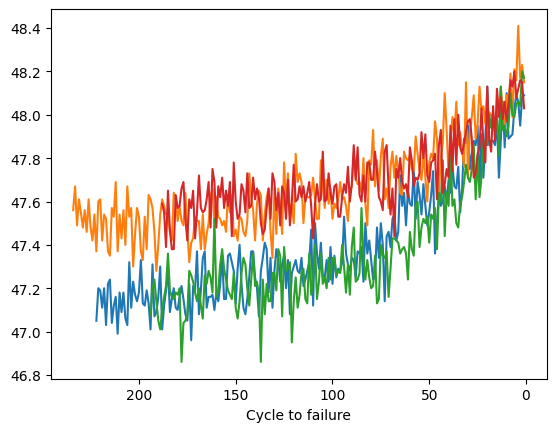

In [18]:
plot_feature(df, 'p02', timeseries=[10, 20, 30, 40])

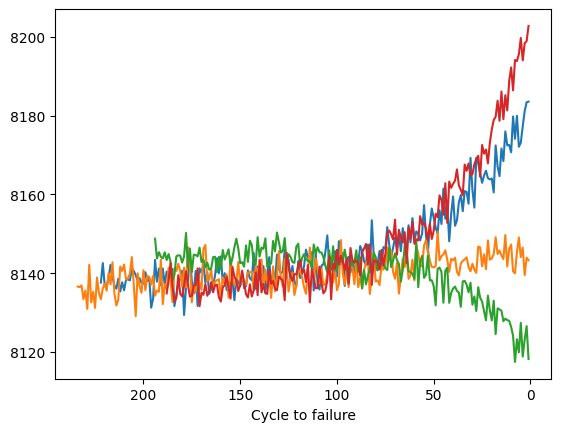

In [19]:
plot_feature(df, 'p05', timeseries=[10, 20, 30, 40])

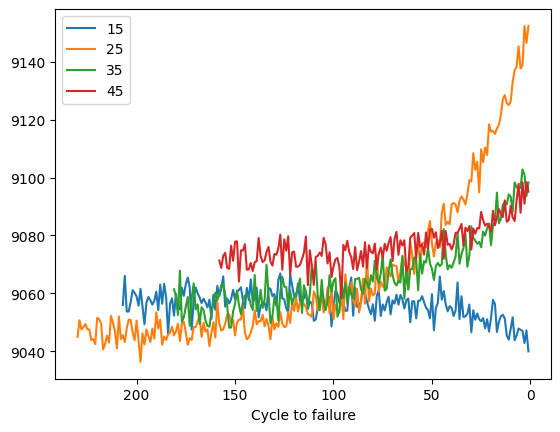

In [20]:
plot_feature(df, 'p20', timeseries=[15, 25, 35, 45], show_legend=True)

### EDA conclusions: 

- `p00`, `p01`, `p07`, `p09`, `p10`, `p16` are the constant values and should be removed.
- data scaling by each features are nessesary and should be standard.
- data of the different timeseries are consistent and could be same preprocessing.
- train-test split must be by timeseries and may be random.
- features are high-correlated. <b>features are not distributed independently</b>.
- bayesian method shouldn't work with this data. Other ML method may have some problems.
- `p05` and `p20` has a different distribution of values by timeseries.  I'd like to remove it both.
- `p17` looks like a binary feature.
- `s1` and `s2` looks like a random noise.

## Problem statement

The business wants to predict the failure cycle in order to avoid failures. For example, to repair the engine before failure.<br>
Business Hypothesis: Client will be happy if they know about the next failure within the next 30 cycles.<br>
Let's formulate the ML problems in two way:
- regression problem to predict cycle before failure (TTF problem)
- classification problem to predict failure in last 30 cycles

Add labels for each problem to dataset

In [45]:
# add regression label
timeseries_lenght = [df[df['id'] == i]['cycle'].max() for i in range(1, df.id.max() + 1)]
cycle_to_failure = []
for i in range(len(timeseries_lenght)):
    cycle_to_failure.extend(list(timeseries_lenght[i] + 1 - df['cycle'][df.id == i + 1]))
df['cycle_to_fail'] = cycle_to_failure

In [46]:
# add classification label
df['fail_next_30'] = np.where(df['cycle_to_fail'].to_numpy() <= 30, 1, 0)

#### Metrics

- Regression problem: TTF (MAE), number of timeseries with overstated predicted TTF.
- Classification problem: Precision, number of timeseries with understated predicted probabily. ROC-AUC and accuracy are not good metrics, because too many negative labels.
- Check the worst predicion by timeseries to found the worst result.

## Data preprocessing

Remove constant features

In [110]:
df_drop = df.drop(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], axis=1)

Remove one of highly correlated feature

In [111]:
# df_drop = df_drop.drop(['p20'], axis=1)
df_drop = df_drop.drop(['p05', 'p20'], axis=1)

Make `p17` is binary

In [112]:
df_drop['p17'] = np.where(df['p17'].to_numpy() > 21.605, 1., 0.)

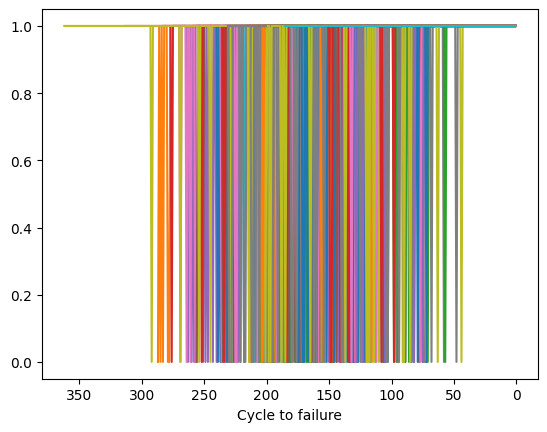

In [113]:
plot_feature(df_drop, 'p17')

In [51]:
df_drop

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2,cycle_to_fail,fail_next_30
0,1,1,47.47,521.66,2388.02,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,1.0,554.36,2388.06,-0.0007,-0.0004,192,0
1,1,2,47.49,522.28,2388.07,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,1.0,553.75,2388.04,0.0019,-0.0003,191,0
2,1,3,47.27,522.42,2388.03,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,1.0,554.26,2388.08,-0.0043,0.0003,190,0
3,1,4,47.13,522.86,2388.08,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,1.0,554.45,2388.11,0.0007,0.0000,189,0
4,1,5,47.28,522.19,2388.04,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,1.0,554.00,2388.06,-0.0019,-0.0002,188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,1.0,552.24,2388.20,0.0042,0.0002,5,1
16134,80,182,48.41,520.06,2388.12,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,1.0,551.60,2388.16,-0.0014,0.0004,4,1
16135,80,183,48.04,519.67,2388.21,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,1.0,551.78,2388.12,0.0018,0.0000,3,1
16136,80,184,48.04,519.72,2388.20,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,1.0,551.78,2388.17,-0.0024,0.0002,2,1


Split to train and test

In [52]:
np.random.seed(SEED)
random_idx = np.random.permutation(np.arange(1, df.id.max() + 1))
train_idx = random_idx[:int(df.id.max() * TRAIN_SPLIT_SIZE)]
test_idx = random_idx[int(df.id.max() * TRAIN_SPLIT_SIZE):]

df_train = df_drop[df_drop['id'].isin(train_idx)]
df_test = df_drop[df_drop['id'].isin(test_idx)]

In [53]:
# train timeseries id
np.sort(train_idx)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
       23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 62, 63,
       65, 66, 67, 68, 69, 71, 73, 74, 76, 77, 78, 79, 80], dtype=int64)

In [54]:
# test timeseries id
np.sort(test_idx)

array([ 2,  3, 15, 21, 22, 24, 30, 38, 52, 53, 60, 61, 64, 70, 72, 75],
      dtype=int64)

## Baseline model

#### Regression task

In [55]:
X_regr_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_train = df_train['cycle_to_fail']
X_regr_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_test = df_test['cycle_to_fail']

In [56]:
# Normalize dataset
std_scaler = StandardScaler()
std_scaler.fit_transform(X_regr_train)
X_train_scaled = std_scaler.transform(X_regr_train)
X_test_scaled = std_scaler.transform(X_regr_test)

In [57]:
lr_regr = LinearRegression().fit(X_train_scaled, y_regr_train)
lr_regr.score(X_test_scaled, y_regr_test)

0.6945285962318488

In [58]:
lr_pred = lr_regr.predict(X_test_scaled)

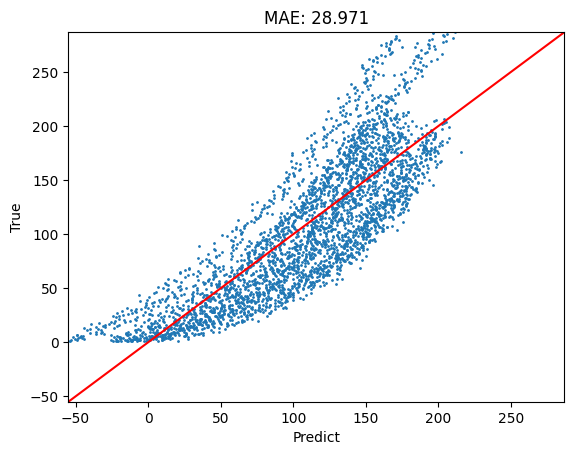

In [59]:
crossplot_pred(lr_pred, y_regr_test)

In [60]:
X_regr_test['predict'] = lr_pred
X_regr_test['id'] = df_test['id']  # return removed feature

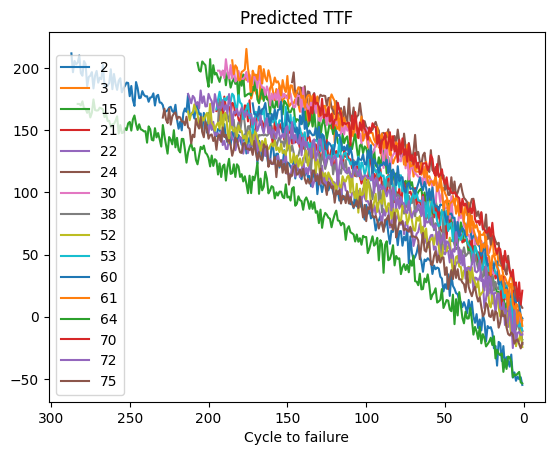

In [61]:
plot_feature(X_regr_test, 'predict', show_legend=True, title='Predicted TTF')

calculate mean predicted TTF at last 30 cycle of timeseries

In [62]:
X_regr_test['id'] = df_test['id']
X_regr_test['target'] = y_regr_test
X_regr_test[X_regr_test['target'] <= 30].groupby(by='id').mean()['predict'].sort_values()

id
64   -30.803394
2    -26.580905
75    -3.837508
52     4.746790
22     9.002935
72    10.655057
15    18.815139
38    20.122270
53    24.654758
21    26.050138
30    29.307459
60    31.751299
61    32.550430
3     40.174080
24    49.772130
70    51.053183
Name: predict, dtype: float64

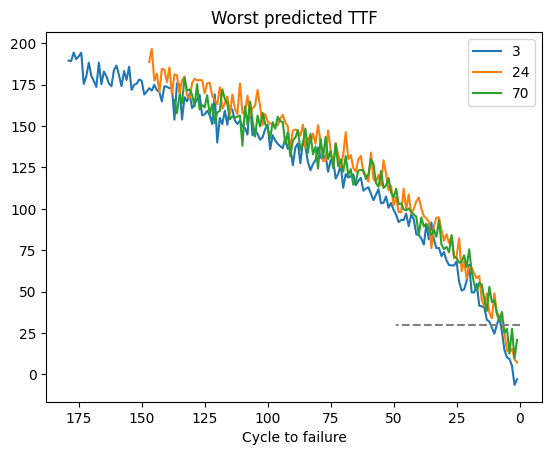

In [87]:
plot_feature(X_regr_test, 'predict', timeseries=[3, 24, 70], show_legend=True, title='Worst predicted TTF')
plt.plot(np.arange(50), np.full(50, 30), color='gray', ls='--')

In [89]:
X_regr_test[X_regr_test.id == 24]['predict'][-30:]

4850    80.854765
4851    84.681565
4852    79.344237
4853    83.621297
4854    70.065751
4855    71.212454
4856    82.236410
4857    62.324851
4858    68.213926
4859    57.948018
4860    64.881767
4861    64.564350
4862    60.797794
4863    58.186683
4864    59.473081
4865    44.924498
4866    41.104352
4867    48.887966
4868    37.475356
4869    33.833914
4870    48.984806
4871    37.523097
4872    35.252291
4873    31.884062
4874    25.191724
4875    14.409906
4876    13.560696
4877    15.367122
4878     9.258742
4879     7.098431
Name: predict, dtype: float64

The worst result of linear regression for timeseries 24 is to show TTF less than 30 before real failure in only 6 cycles.

### Classification task

In [90]:
X_cls_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_cls_train = df_train['fail_next_30']
X_cls_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_cls_test = df_test['fail_next_30']

In [91]:
df_train

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2,cycle_to_fail,fail_next_30
0,1,1,47.47,521.66,2388.02,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,1.0,554.36,2388.06,-0.0007,-0.0004,192,0
1,1,2,47.49,522.28,2388.07,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,1.0,553.75,2388.04,0.0019,-0.0003,191,0
2,1,3,47.27,522.42,2388.03,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,1.0,554.26,2388.08,-0.0043,0.0003,190,0
3,1,4,47.13,522.86,2388.08,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,1.0,554.45,2388.11,0.0007,0.0000,189,0
4,1,5,47.28,522.19,2388.04,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,1.0,554.00,2388.06,-0.0019,-0.0002,188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,1.0,552.24,2388.20,0.0042,0.0002,5,1
16134,80,182,48.41,520.06,2388.12,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,1.0,551.60,2388.16,-0.0014,0.0004,4,1
16135,80,183,48.04,519.67,2388.21,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,1.0,551.78,2388.12,0.0018,0.0000,3,1
16136,80,184,48.04,519.72,2388.20,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,1.0,551.78,2388.17,-0.0024,0.0002,2,1


In [92]:
# Normalize dataset
std_scaler = StandardScaler()
std_scaler.fit_transform(X_cls_test)
X_train_scaled = std_scaler.transform(X_cls_train)
X_test_scaled = std_scaler.transform(X_cls_test)

In [93]:
cls_regr = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_cls_train)
cls_regr.score(X_test_scaled, y_cls_test)

0.9514232673267327

In [94]:
cls_pred = cls_regr.predict(X_test_scaled)
cls_pred_proba = cls_regr.predict_proba(X_test_scaled)

In [95]:
conf_matrix = metrics.confusion_matrix(y_cls_test, cls_pred)
true_negative = conf_matrix[0, 0]
true_positive = conf_matrix[1, 1]
false_negative = conf_matrix[0, 1]
false_positive = conf_matrix[1, 0]

In [96]:
recall = true_positive / (false_negative + true_positive)
precision = true_positive / (false_positive + true_positive)
print(f"Recall is {recall:.3f}, Precision is {precision:.3f}")

Recall is 0.858, Precision is 0.806


Plot predicted probability.

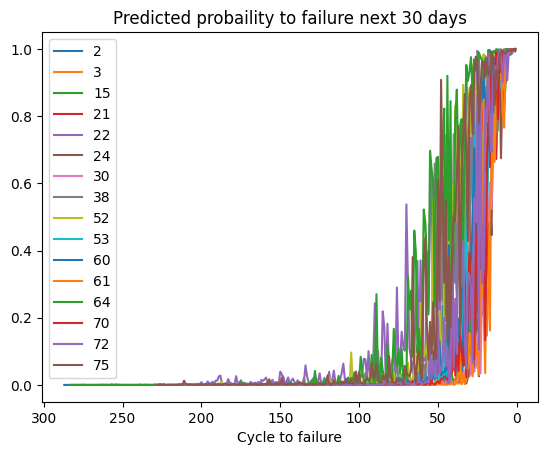

In [97]:
X_cls_test['predict'] = cls_pred_proba[:, 1]
X_cls_test['id'] = df_test['id']  # return removed feature
plot_feature(X_cls_test, 'predict', show_legend=True, title='Predicted probaility to failure next 30 days')

calculate mean predicted probabity at last 30 cycle of timeseries

In [98]:
X_cls_test['target'] = y_cls_test
X_cls_test[X_cls_test['target'] == 1].groupby(by='id').mean()['predict'].sort_values()

id
61    0.588603
30    0.593058
24    0.594743
3     0.595562
15    0.682124
70    0.713076
21    0.735649
72    0.759026
53    0.766483
60    0.833386
38    0.871838
2     0.884528
22    0.913315
52    0.934500
75    0.940550
64    0.976073
Name: predict, dtype: float64

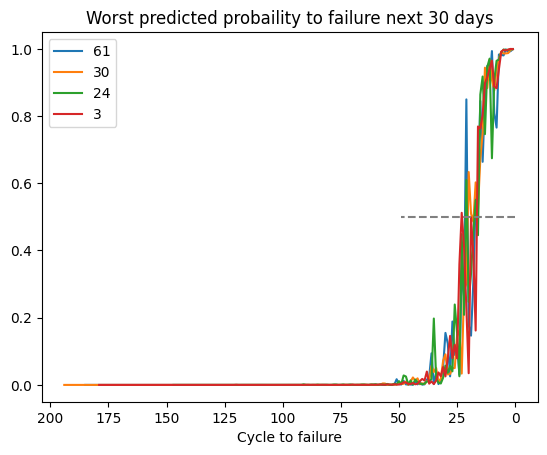

In [99]:
plot_feature(X_cls_test, 'predict', timeseries=[61, 30, 24, 3], show_legend=True, title='Worst predicted probaility to failure next 30 days')
plt.plot(np.arange(50), np.full(50, .5), color='gray', ls='--')

In [108]:
X_cls_test[X_cls_test.id == 24]['predict'][-30:]

4850    0.057515
4851    0.035986
4852    0.057240
4853    0.040312
4854    0.239264
4855    0.155096
4856    0.025700
4857    0.448759
4858    0.208637
4859    0.609577
4860    0.246976
4861    0.331291
4862    0.452454
4863    0.550171
4864    0.445464
4865    0.864129
4866    0.917679
4867    0.746245
4868    0.946460
4869    0.970847
4870    0.674443
4871    0.906668
4872    0.964508
4873    0.967878
4874    0.989383
4875    0.997921
4876    0.996890
4877    0.996640
4878    0.998793
4879    0.999367
Name: predict, dtype: float64

The worst result of linear regression for timeseries 24 is to show TTF less than 30 before real failure in only 15 cycles.

#### Baseline conclusion
##### Regression task
- linear regression has TTF MAE value is 29.
- 3 out of 16 engine test series drop predicted TTF less than 30 cycle when real TTF is 7 cycles.
- this will cause the engine to fail until it is stopped for repairs.
##### Classification task
- precision is 0.806.
- 4 out of 16 engine test series predict failure in next 30 cycle when real TTF is 15 cycles. It's better then linear regression.
- logistic regression have nervous cycle-to-cycle predicted probabity. Operator of ML system will not trust this prediction and could be ignore it.

## Transformers

Ideas: 
- Use the transformers architecture to solve classification and regression problem.
- Pass engine parameters for the last 30 cycles to the model and predict TTF and failure within 30 days.
- Add unsymmetrical losses to prevent predicting less than the real life cycle.

In [963]:
# normalize data
X_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_train = df_train['cycle_to_fail']
y_cls_train = df_train['fail_next_30']

X_regr_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
X_cls_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_test = df_test['cycle_to_fail']
y_cls_test = df_test['fail_next_30']

std_scaler = StandardScaler()
std_scaler.fit_transform(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

#### Regression task

In [701]:
# create dataloader
train_dataloader = create_dataloader(df_train, X_train_scaled, y_regr_train, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
test_dataloader = create_dataloader(df_test, X_test_scaled, y_regr_test, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE, shuffle=False, drop_last=False)

In [812]:
model = TimeSeriesTransformer(d_model=16, nhead=4, num_encoder_layers=2, dim_feedforward=64, dropout=0.4, window_size=WINDOW_SIZE)

In [814]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = AsymmetricMSELoss(scale=2.)

In [815]:
def train(model, n_epochs, train_dataloader, optimizer, criterion, test_dataloader=None, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    best_model = None
    train_loss = []
    test_loss = []
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        model.train()
        loss_list = []
        ttf_list = []
        for data, target, _ in train_dataloader:
            data = data.to(device)
            target = target.to(device)
            predict = model(data)
            
            loss = criterion(predict, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().cpu().mean())
        train_loss.append(np.nanmean(loss_list))

        model.eval()
        if test_dataloader is not None:
            test_loss_list = []
            ttf_list = []
            for data, target, _ in test_dataloader:
                data = data.to(device)
                target = target.to(device)
                predicted = model(data)
                test_loss_list.append(criterion(predicted, target).detach().cpu().mean())
            test_loss.append(np.nanmean(np.array(test_loss_list)))

        if verbose:
            print(f'epoch: {epoch}/{n_epochs}, '
                  f'train_loss: {train_loss[-1]:.3f}, '
                  f'test_loss: {test_loss[-1]:.3f}, '
                  f'Time: {time.time() - start_time:.3f}')

In [816]:
train(model, N_EPOCHS, train_dataloader, optimizer, criterion, test_dataloader=test_dataloader)

epoch: 1/60, train_loss: 4514.153, test_loss: 2125.573, Time: 0.639
epoch: 2/60, train_loss: 2816.466, test_loss: 2183.490, Time: 0.410
epoch: 3/60, train_loss: 2618.829, test_loss: 2289.346, Time: 0.368
epoch: 4/60, train_loss: 2515.406, test_loss: 2617.938, Time: 0.372
epoch: 5/60, train_loss: 2553.168, test_loss: 2884.099, Time: 0.367
epoch: 6/60, train_loss: 2484.544, test_loss: 2872.837, Time: 0.368
epoch: 7/60, train_loss: 2415.952, test_loss: 2527.074, Time: 0.364
epoch: 8/60, train_loss: 2365.075, test_loss: 2365.995, Time: 0.366
epoch: 9/60, train_loss: 2150.997, test_loss: 2296.484, Time: 0.369
epoch: 10/60, train_loss: 2229.568, test_loss: 3704.651, Time: 0.363
epoch: 11/60, train_loss: 2338.040, test_loss: 2648.509, Time: 0.372
epoch: 12/60, train_loss: 1752.106, test_loss: 2975.055, Time: 0.377
epoch: 13/60, train_loss: 2117.156, test_loss: 2381.063, Time: 0.385
epoch: 14/60, train_loss: 2146.519, test_loss: 2563.727, Time: 0.385
epoch: 15/60, train_loss: 2066.390, test_lo

In [818]:
predicted, idx = predict(model, test_dataloader, batch_size=BATCH_SIZE)

In [819]:
pred_ = np.full(y_regr_pred.shape[0], np.nan)
for i, pred in zip(idx, predicted):
    pred_[i + WINDOW_SIZE - 1] = pred

In [820]:
X_regr_test['predict'] = pred_
X_regr_test['id'] = df_test['id']  # return removed feature

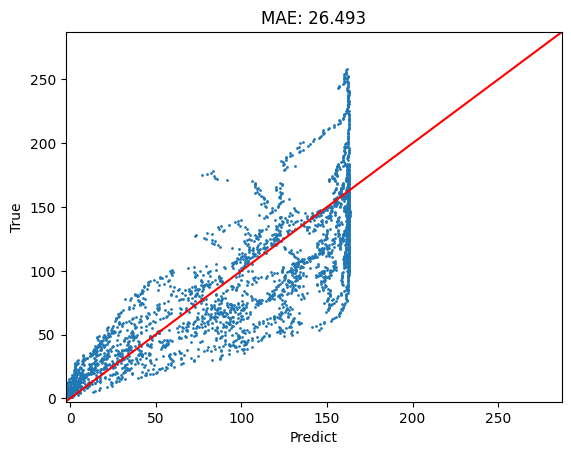

In [821]:
crossplot_pred(pred_, y_regr_test)

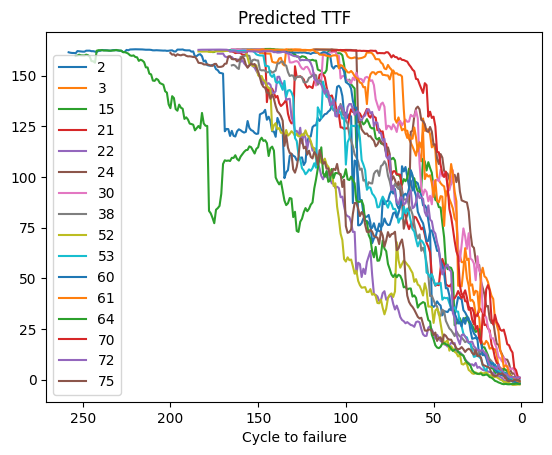

In [822]:
plot_feature(X_regr_test, 'predict', show_legend=True, title='Predicted TTF')

Calculate TTF at last 30 cycles

In [826]:
X_regr_test['id'] = df_test['id']
X_regr_test['target'] = y_regr_test
X_regr_test[X_regr_test['target'] <= 30].groupby(by='id').mean()['predict'].sort_values()

id
64     0.686911
52     1.022641
22     2.892339
75     5.242747
53     6.171636
38     7.445081
72     8.242798
60     9.047683
2      9.196075
15    10.581109
21    15.283955
3     15.436761
70    24.825980
30    25.582712
61    27.675086
24    29.558009
Name: predict, dtype: float64

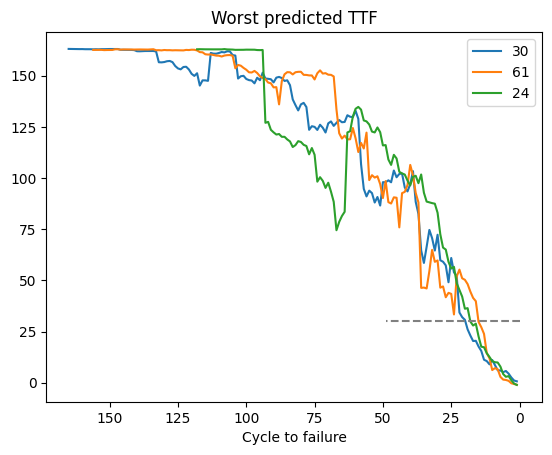

In [830]:
plot_feature(X_regr_test, 'predict', timeseries=[30, 61, 24], show_legend=True, title='Worst predicted TTF')
plt.plot(np.arange(50), np.full(50, 30), color='gray', ls='--')

In [831]:
X_regr_test[X_regr_test.id == 61]['predict'][-30:]

12097    59.736214
12098    46.460506
12099    47.065968
12100    41.769955
12101    43.916206
12102    43.415253
12103    33.368538
12104    51.936588
12105    55.267300
12106    51.030529
12107    50.284340
12108    48.192120
12109    44.536949
12110    41.449795
12111    39.846027
12112    29.725786
12113    27.133820
12114    23.866047
12115    14.478800
12116    11.961057
12117     6.210532
12118     7.137270
12119     6.595792
12120     2.885267
12121     1.539125
12122     1.365829
12123     0.923926
12124    -0.262393
12125    -0.617770
12126    -0.966805
Name: predict, dtype: float64

#### classification task

In [978]:
# create dataloader
train_dataloader = create_dataloader(df_train, X_train_scaled, y_cls_train, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
test_dataloader = create_dataloader(df_test, X_test_scaled, y_cls_test, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE, shuffle=False, drop_last=False)

In [979]:
model = TimeSeriesTransformer(d_model=16, nhead=4, num_encoder_layers=2, dim_feedforward=64, dropout=0.4, window_size=WINDOW_SIZE, add_sigmoid=True)

In [980]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = AsymmetricBCELoss(scale=5.)

In [981]:
train(model, N_EPOCHS, train_dataloader, optimizer, criterion, test_dataloader=test_dataloader)

epoch: 1/60, train_loss: 1.094, test_loss: 0.645, Time: 0.104
epoch: 2/60, train_loss: 0.612, test_loss: 0.496, Time: 0.098
epoch: 3/60, train_loss: 0.622, test_loss: 0.577, Time: 0.098
epoch: 4/60, train_loss: 0.442, test_loss: 0.459, Time: 0.088
epoch: 5/60, train_loss: 0.514, test_loss: 0.478, Time: 0.077
epoch: 6/60, train_loss: 0.453, test_loss: 0.558, Time: 0.076
epoch: 7/60, train_loss: 0.490, test_loss: 0.475, Time: 0.079
epoch: 8/60, train_loss: 0.547, test_loss: 0.447, Time: 0.074
epoch: 9/60, train_loss: 0.460, test_loss: 0.397, Time: 0.072
epoch: 10/60, train_loss: 0.225, test_loss: 0.403, Time: 0.077
epoch: 11/60, train_loss: 0.371, test_loss: 0.463, Time: 0.066
epoch: 12/60, train_loss: 0.595, test_loss: 0.392, Time: 0.063
epoch: 13/60, train_loss: 0.292, test_loss: 0.363, Time: 0.065
epoch: 14/60, train_loss: 0.360, test_loss: 0.342, Time: 0.065
epoch: 15/60, train_loss: 0.361, test_loss: 0.321, Time: 0.064
epoch: 16/60, train_loss: 0.330, test_loss: 0.319, Time: 0.064
e

In [982]:
predicted, idx = predict(model, test_dataloader, batch_size=BATCH_SIZE)

In [983]:
cls_pred = np.full(y_regr_pred.shape[0], np.nan)
for i, pred in zip(idx, predicted):
    cls_pred[i + WINDOW_SIZE - 1] = pred

In [985]:
y_test = pd.DataFrame(y_cls_test)
y_test['predict_proba'] = cls_pred
y_test['predict'] = y_test['predict_proba'] > .5
y_test.dropna(inplace=True)

In [986]:
conf_matrix = metrics.confusion_matrix(y_test['fail_next_30'], y_test['predict'])
true_negative = conf_matrix[0, 0]
true_positive = conf_matrix[1, 1]
false_negative = conf_matrix[0, 1]
false_positive = conf_matrix[1, 0]

In [987]:
recall = true_positive / (false_negative + true_positive)
precision = true_positive / (false_positive + true_positive)
print(f"Recall is {recall:.3f}, Precision is {precision:.3f}")

Recall is 0.744, Precision is 0.985


Plot predicted probability.

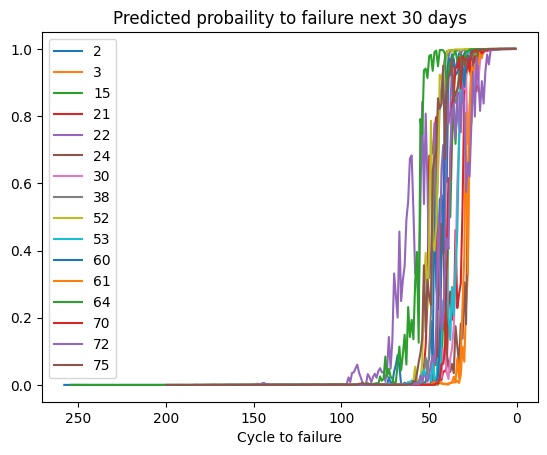

In [988]:
X_cls_test['predict'] = y_test['predict_proba']
X_cls_test['id'] = df_test['id']  # return removed feature
plot_feature(X_cls_test, 'predict', show_legend=True, title='Predicted probaility to failure next 30 days')

calculate mean predicted probabity at last 30 cycle of timeseries

In [989]:
X_cls_test['target'] = y_test['fail_next_30']
X_cls_test[X_cls_test['target'] == 1].groupby(by='id').mean()['predict'].sort_values()

id
3     0.908392
24    0.913578
72    0.915756
61    0.934027
30    0.958284
21    0.978141
15    0.990333
22    0.991579
70    0.992319
60    0.992607
75    0.993219
53    0.994628
64    0.998116
2     0.998189
38    0.999299
52    0.999807
Name: predict, dtype: float64

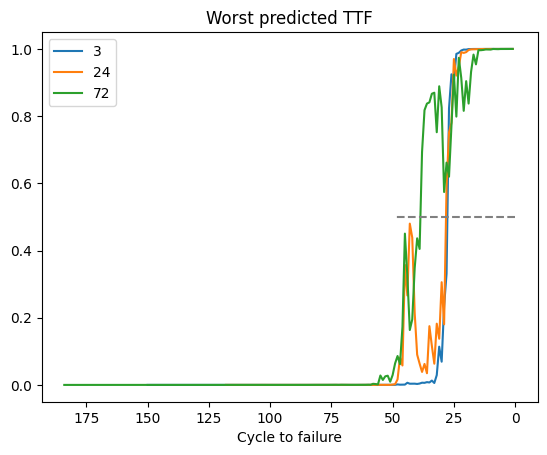

In [994]:
plot_feature(X_cls_test, 'predict', timeseries=[3, 24, 72], show_legend=True, title='Worst predicted TTF')
plt.plot(np.arange(50), np.full(50, .5), color='gray', ls='--')

In [995]:
X_cls_test[X_cls_test.id == 3]['predict'][-30:]

628    0.069165
629    0.234591
630    0.331198
631    0.823133
632    0.924564
633    0.905706
634    0.985179
635    0.988375
636    0.995395
637    0.998084
638    0.997833
639    0.999475
640    0.999723
641    0.999805
642    0.999868
643    0.999897
644    0.999947
645    0.999964
646    0.999972
647    0.999988
648    0.999990
649    0.999990
650    0.999995
651    0.999989
652    0.999996
653    0.999992
654    0.999990
655    0.999982
656    0.999990
657    0.999993
Name: predict, dtype: float64

#### Transformers conclusion
Overall: Transformers tend to overfit on the train dataset. This is corrected by a large `weight_decay` value and a dropout rate.
##### Regression task
- Transformer has TTF MAE value is 26.5. It's better than base model. Also asymmetric losses raise the symmetric metrics.
- the worst of 16 engine test series drop predicted TTF less than 30 cycle when real TTF is 15 cycles. It's twice better that base model.
- 10 out of 16 engine test series predicted TTF much less than real. It could be fixed by research of scale factor
##### Classification task
- precision is 0.985. It's much better than base model. Choose scale factor for asymmetric loss could improve precision by reducing recall.
- the worst of of 16 engine test series predict failure in next 30 cycle when real TTF is 26 cycles. It's almost twice better that base model.

## Conclusions

1. Makes the EDA of present dataset and clear it.
2. Put forward the bisiness hypothesis and formulate it as ML problem.
3. Fit еру baseline models and find it weak places.
4. Weak places fixed with transformer modelsa and asymmetric loss.
5. Classification models give the safer predictions.